<a href="https://colab.research.google.com/github/ShahdMoataz20/E-commerce-Customers-Segmentation/blob/main/E_commerce_Customers_Segmentation_(Microsoft_project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
file_path = "/content/E-commerce_data.xlsx"
xls = pd.ExcelFile(file_path)
print(xls.sheet_names)

['customers', 'genders', 'cities', 'transactions', 'branches', 'merchants']


In [38]:
customers = pd.read_excel(xls, sheet_name="customers")
genders = pd.read_excel(xls, sheet_name="genders")
cities = pd.read_excel(xls, sheet_name="cities")
transactions = pd.read_excel(xls, sheet_name="transactions")
branches = pd.read_excel(xls, sheet_name="branches")
merchants = pd.read_excel(xls, sheet_name="merchants")

## **Data Preprocessing**

In [39]:
# Merge Customers with Genders and Cities
customers = customers.merge(genders, on="gender_id", how="left")
customers = customers.merge(cities, on="city_id", how="left")

# Merge Transactions with Customers
transactions = transactions.merge(customers, on="customer_id", how="left")

In [40]:
# Convert dates to datetime
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])
transactions["burn_date"] = pd.to_datetime(transactions["burn_date"])

In [41]:
# Create a feature for transaction frequency per customer
customer_txn_count = transactions.groupby("customer_id")["transaction_id"].count().reset_index()
customer_txn_count.columns = ["customer_id", "transaction_count"]

print(customer_txn_count.head())

   customer_id  transaction_count
0            1                  7
1            2                  3
2            3                  5
3            4                  1
4            5                  4


In [42]:
print(transactions.columns)

Index(['transaction_id', 'customer_id', 'transaction_date',
       'transaction_status', 'coupon_name', 'burn_date', 'branch_id',
       'join_date', 'city_id', 'gender_id', 'gender_name', 'city_name'],
      dtype='object')


In [43]:
# Merge transaction frequency back to customers
customers = customers.merge(customer_txn_count, on="customer_id", how="left")
customers["transaction_count"] = customers["transaction_count"].fillna(0)

customers.head()

,customer_id,join_date,city_id,gender_id,gender_name,city_name,transaction_count
0,1,2022-01-08,7,1,Male,Mansoura,7.0
1,2,2023-05-02,20,2,Female,Sohag,3.0
2,3,2023-05-14,15,1,Male,Aswan,5.0
3,4,2022-11-25,11,2,Female,Ismailia,1.0
4,5,2023-04-26,8,1,Male,El-Mahalla El-Kubra,4.0


## **Feature Selection**

In [44]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical variables (gender, city)
label_enc = LabelEncoder()

# Select features for clustering
features = customers[["transaction_count", "gender_id", "city_id"]]

# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [45]:
customers.head()

,customer_id,join_date,city_id,gender_id,gender_name,city_name,transaction_count
0,1,2022-01-08,7,1,Male,Mansoura,7.0
1,2,2023-05-02,20,2,Female,Sohag,3.0
2,3,2023-05-14,15,1,Male,Aswan,5.0
3,4,2022-11-25,11,2,Female,Ismailia,1.0
4,5,2023-04-26,8,1,Male,El-Mahalla El-Kubra,4.0


## **Customer Segmentation using K-Means**

In [46]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

WCSS values for different k:
k = 1, WCSS = 3000.000000000002
k = 2, WCSS = 2336.6206199443996
k = 3, WCSS = 1619.2454320688273
k = 4, WCSS = 1233.7206620477089
k = 5, WCSS = 1055.725797287578
k = 6, WCSS = 771.0766542667878
k = 7, WCSS = 671.0327053609598
k = 8, WCSS = 621.6080912692377
k = 9, WCSS = 530.4626585226845
k = 10, WCSS = 492.5587213524429


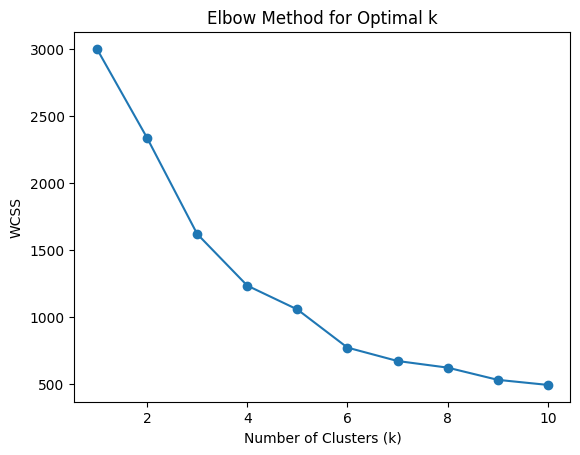

In [47]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []

print("WCSS values for different k:")
for k in range(1, 11):  # Testing k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    print(f"k = {k}, WCSS = {kmeans.inertia_}")

# Plot WCSS vs. k
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal k")
plt.show()


In [50]:
# Fit K-Means with optimal K (let’s assume 3 clusters based on elbow method)
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
customers["cluster"] = kmeans.fit_predict(scaled_features)

## **Model Evaluation**

In [52]:
from sklearn.metrics import silhouette_score

best_k = 2
best_score = -1

for k in range(2, 11):  # Avoid k=1 because silhouette score is not valid for one cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, cluster_labels)

    if score > best_score:
        best_score = score
        best_k = k

print(f"Best k: {best_k} with Silhouette Score: {best_score}")

Best k: 6 with Silhouette Score: 0.40146108955786375


## **Segment Analysis**

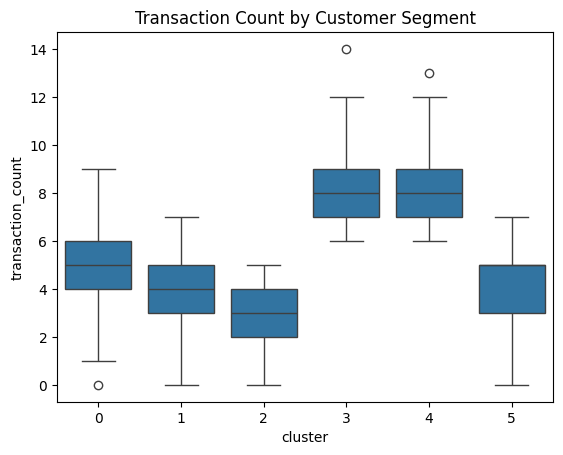

cluster
2    191
5    190
0    186
1    185
4    132
3    116
Name: count, dtype: int64


,cluster,transaction_count,gender_id,city_id
0,0,4.881720,1,15
1,1,3.816216,2,20
2,2,3.204188,1,8
3,3,7.801724,2,4
4,4,7.931818,1,7
5,5,4.326316,2,1


In [61]:
import seaborn as sns

# Visualizing clusters
sns.boxplot(x="cluster", y="transaction_count", data=customers)
plt.title("Transaction Count by Customer Segment")
plt.show()

# Count of customers in each segment
print(customers["cluster"].value_counts())

# Analyze cluster characteristics
cluster_analysis = customers.groupby("cluster").agg({
    "transaction_count": "mean",
    "gender_id": "first",
    "city_id": "first"
}).reset_index()

cluster_analysis

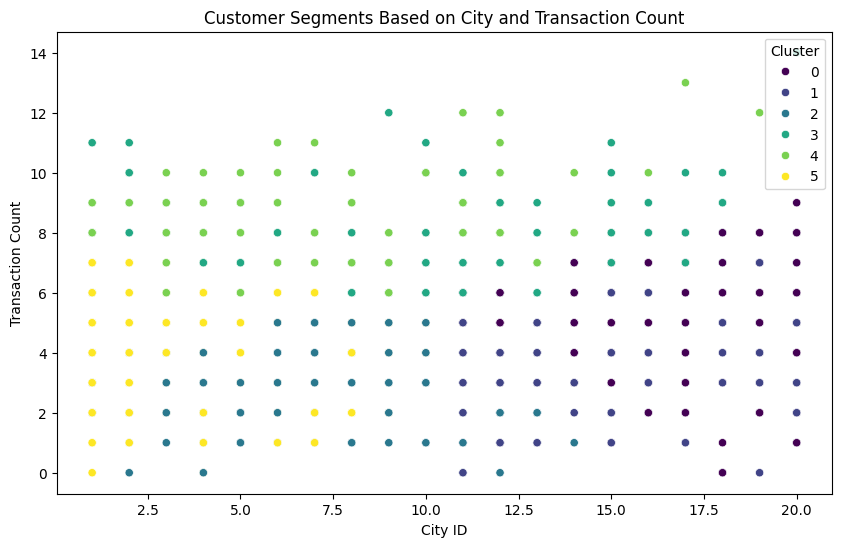

In [68]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=customers["city_id"], y=customers["transaction_count"], hue=customers["cluster"], palette="viridis")
plt.xlabel("City ID")
plt.ylabel("Transaction Count")
plt.title("Customer Segments Based on City and Transaction Count")
plt.legend(title="Cluster")
plt.show()

<ipython-input-69-236a75d7c47d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=customers["cluster"], palette="coolwarm")


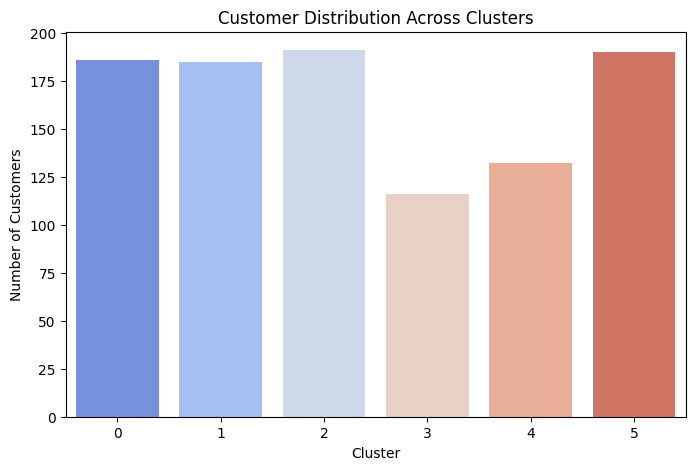

In [69]:
plt.figure(figsize=(8, 5))
sns.countplot(x=customers["cluster"], palette="coolwarm")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution Across Clusters")
plt.show()